In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)
from sklearn.metrics import confusion_matrix
import plotly.express as px
import plotly.figure_factory as ff

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [ ]:
csv_path = os.path.join(path, "Data", "features_3_sec.csv")
df = pd.read_csv(csv_path)
df.head()


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
print("Dataset has",df.shape)

Dataset has (9990, 60)


In [ ]:
audio_path = '/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_path,sr=None)

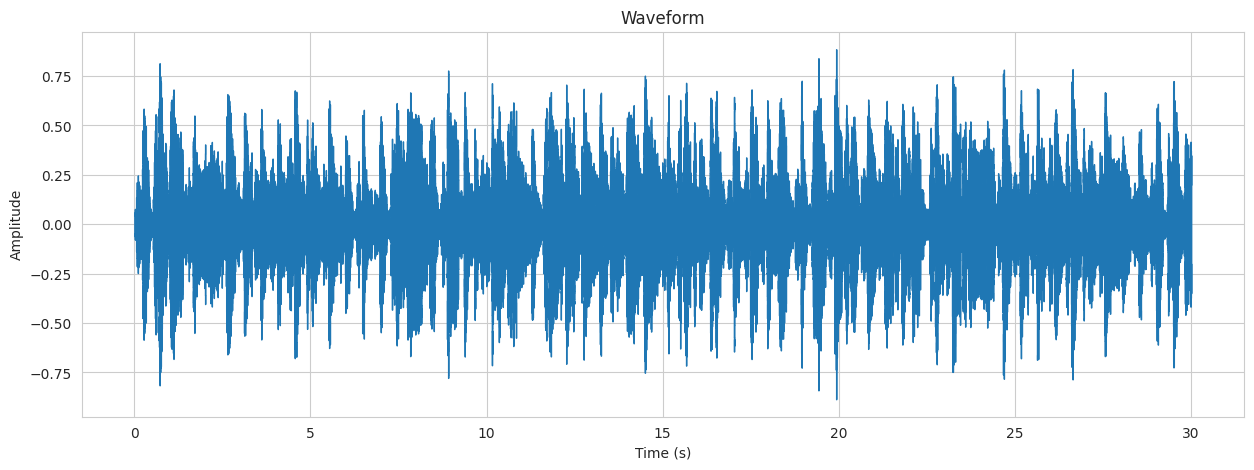

In [ ]:
plt.figure(figsize=(15,5))
lplt.waveshow(audio_data, sr=sr)  # Updated function
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

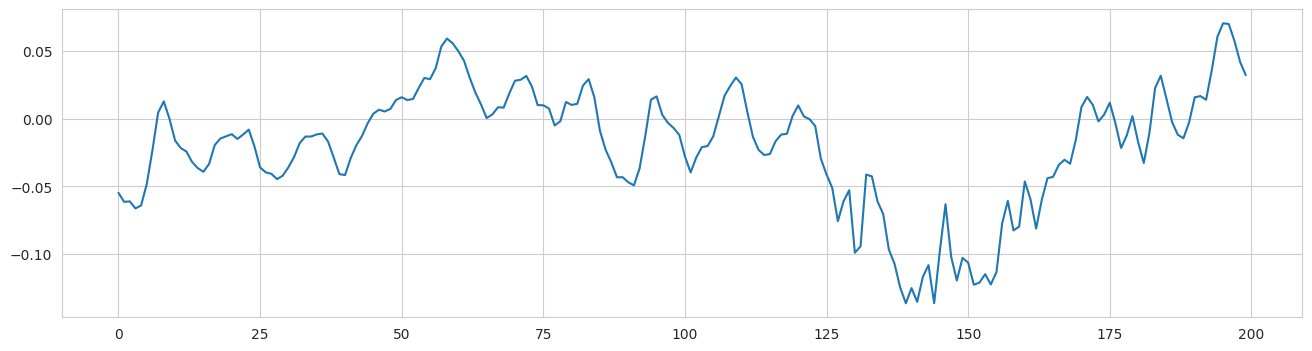

In [ ]:
# plot zoomed audio wave
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

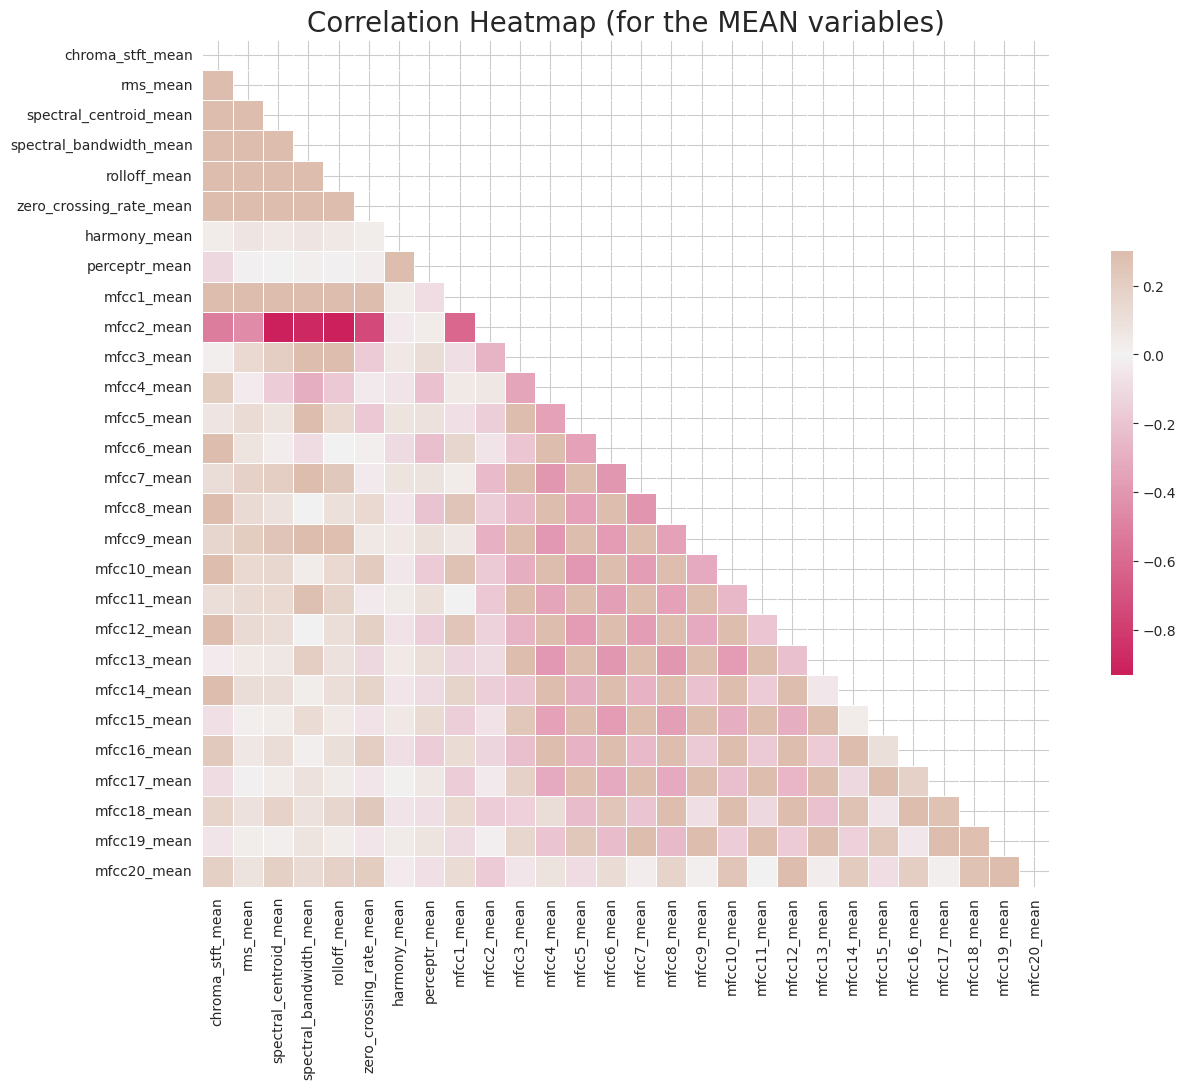

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))  # Changed from np.bool

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s=90, l=45, n=5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("Corr_Heatmap.png")
plt.show()

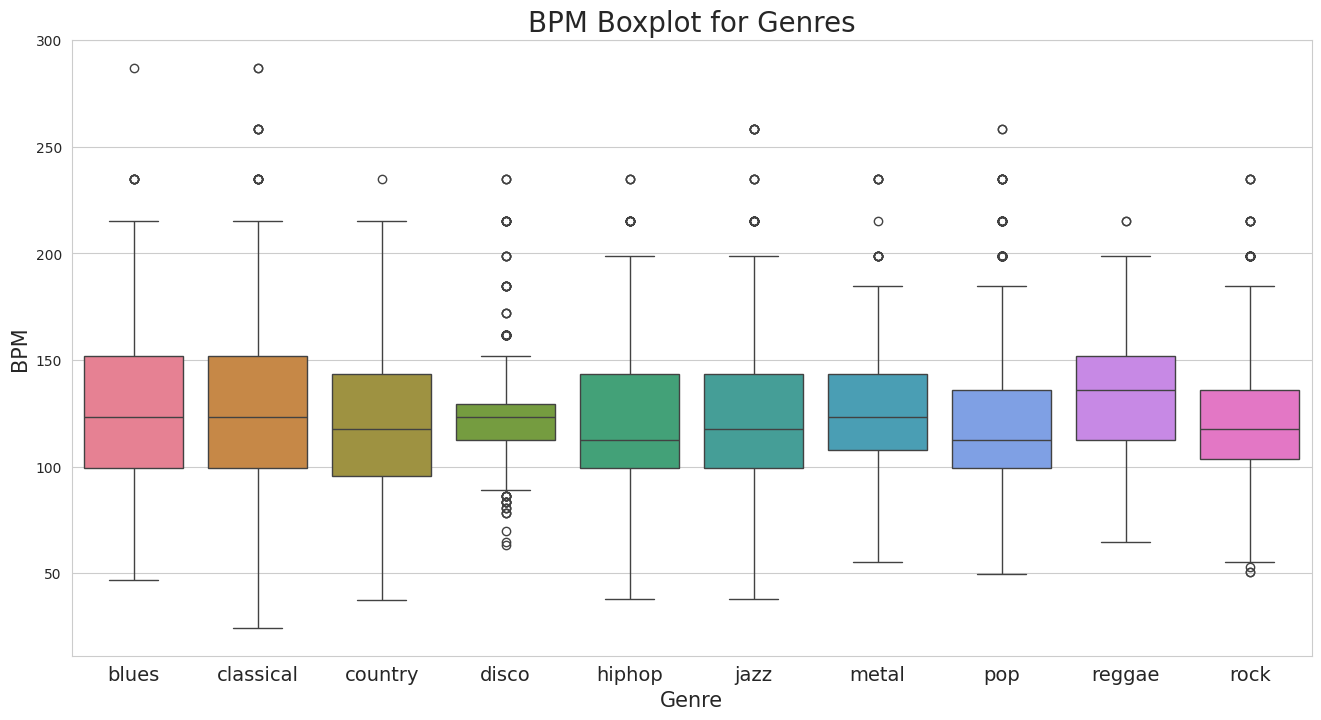

In [ ]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

In [ ]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


Data Preparation and Evalutation Phase

In [ ]:
df.label = [label_index[l] for l in df.label]
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [ ]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [ ]:
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

TF version:- 2.19.0


In [ ]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model.fit(
        X_train, y_train,
        validation_data=(X_dev, y_dev),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[callback]
    )

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

def evaluateModel(model, X_test, y_test):
    """Evaluates the trained model on the test set and prints the classification report."""
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

In [ ]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=9, optimizer='adam')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,650 (221.29 KB)

 Trainable params: 56,650 (221.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/9
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4046 - loss: 1.7499 - val_accuracy: 0.6441 - val_loss: 1.0294
Epoch 2/9
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6854 - loss: 0.9275 - val_accuracy: 0.7194 - val_loss: 0.8379
Epoch 3/9
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7490 - loss: 0.7276 - val_accuracy: 0.7619 - val_loss: 0.7207
Epoch 4/9
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7980 - loss: 0.6005 - val_accuracy: 0.7841 - val_loss: 0.6455
Epoch 5/9
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8294 - loss: 0.5092 - val_accuracy: 0.7983 - val_loss: 0.5979
Epoch 6/9
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8553 - loss: 0.4363 - val_accuracy: 0.8013 - val_loss: 0.5707
Epoch 7/9
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8737 - loss: 0.3780 - val_accuracy: 0.8155 - val_loss: 0.5521
Epoch 8/9
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8896 - loss: 0.3281 - val_accuracy: 0.8251 - val_loss: 0.

Plot Hisotry

Max. Validation Accuracy 0.8427704572677612


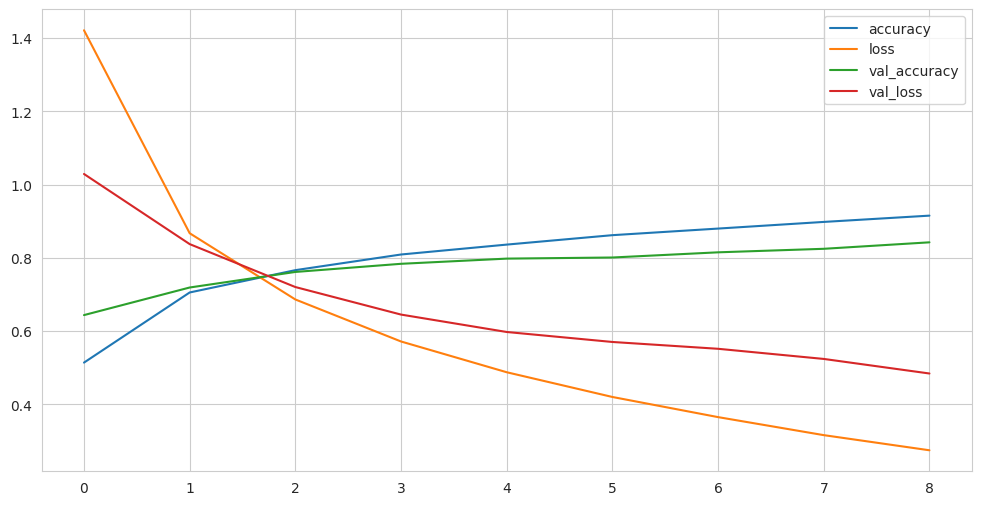

In [ ]:
plotHistory(model_1_history)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


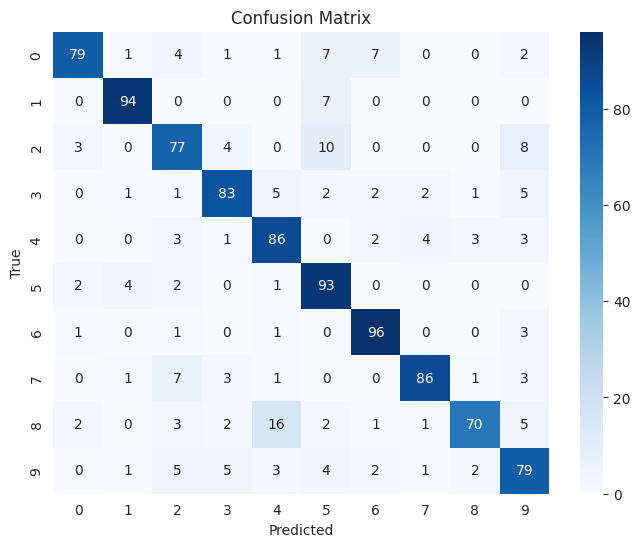


Classification Report:
              precision    recall  f1-score   support

           0     0.9080    0.7745    0.8360       102
           1     0.9216    0.9307    0.9261       101
           2     0.7476    0.7549    0.7512       102
           3     0.8384    0.8137    0.8259       102
           4     0.7544    0.8431    0.7963       102
           5     0.7440    0.9118    0.8194       102
           6     0.8727    0.9412    0.9057       102
           7     0.9149    0.8431    0.8776       102
           8     0.9091    0.6863    0.7821       102
           9     0.7315    0.7745    0.7524       102

    accuracy                         0.8273      1019
   macro avg     0.8342    0.8274    0.8273      1019
weighted avg     0.8341    0.8273    0.8272      1019



In [ ]:
y_pred_probs = model_1.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# If your y_test is a pandas Series, convert to numpy array
y_true = np.array(y_test)

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- Classification Report (Precision, Recall, F1) ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

In [ ]:
def predict_genre(audio_path, model, scaler):
    """
    Loads an audio file, extracts features, and predicts the genre using the trained model.
    """
    try:

        audio_data, sr = librosa.load(audio_path, sr=None)


        features = {
            'chroma_stft_mean': librosa.feature.chroma_stft(y=audio_data, sr=sr).mean(),
            'chroma_stft_var': librosa.feature.chroma_stft(y=audio_data, sr=sr).var(),
            'rms_mean': librosa.feature.rms(y=audio_data).mean(),
            'rms_var': librosa.feature.rms(y=audio_data).var(),
            'spectral_centroid_mean': librosa.feature.spectral_centroid(y=audio_data, sr=sr).mean(),
            'spectral_centroid_var': librosa.feature.spectral_centroid(y=audio_data, sr=sr).var(),
            'spectral_bandwidth_mean': librosa.feature.spectral_bandwidth(y=audio_data, sr=sr).mean(),
            'spectral_bandwidth_var': librosa.feature.spectral_bandwidth(y=audio_data, sr=sr).var(),
            'rolloff_mean': librosa.feature.spectral_rolloff(y=audio_data, sr=sr).mean(),
            'rolloff_var': librosa.feature.spectral_rolloff(y=audio_data, sr=sr).var(),
            'zero_crossing_rate_mean': librosa.feature.zero_crossing_rate(y=audio_data).mean(),
            'zero_crossing_rate_var': librosa.feature.zero_crossing_rate(y=audio_data).var(),
            'harmony_mean': librosa.effects.harmonic(y=audio_data).mean(),
            'harmony_var': librosa.effects.harmonic(y=audio_data).var(),
            'perceptr_mean': librosa.effects.percussive(y=audio_data).mean(),
            'perceptr_var': librosa.effects.percussive(y=audio_data).var(),
            'tempo': librosa.beat.tempo(y=audio_data, sr=sr)[0],

        }


        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=20)
        for i in range(20):
            features[f'mfcc{i+1}_mean'] = mfccs[i].mean()
            features[f'mfcc{i+1}_var'] = mfccs[i].var()

        features_df = pd.DataFrame([features])


        scaled_features = scaler.transform(features_df)

        prediction = model.predict(scaled_features)
        predicted_class = np.argmax(prediction)
        predicted_genre = index_label[predicted_class]

        return predicted_genre

    except Exception as e:
        return f"Error processing audio file: {e}"

audio_file_path = '/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/blues/blues.00001.wav' # Example path
predicted_genre = predict_genre(audio_file_path, model_1, scaler)
print(f"The predicted genre for the song is: {predicted_genre}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
The predicted genre for the song is: blues


In [ ]:
audio_file_path = '/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/classical/classical.00091.wav' # Example path
predicted_genre = predict_genre(audio_file_path, model_1, scaler)
print(f"The predicted genre for the song is: {predicted_genre}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
The predicted genre for the song is: classical


In [ ]:
audio_file_path = '/memphis-trap-wav-349366.mp3' # Example path
predicted_genre = predict_genre(audio_file_path, model_1, scaler)
print(f"The predicted genre for the song is: {predicted_genre}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The predicted genre for the song is: reggae


In [ ]:
audio_file_path = '/you-and-me-215547.wav' # Example path
predicted_genre = predict_genre(audio_file_path, model_1, scaler)
print(f"The predicted genre for the song is: {predicted_genre}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
The predicted genre for the song is: reggae
